<a href="https://colab.research.google.com/github/Rohan-crypt/DeepLearning/blob/main/Exp13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# %%
!pip install torch torchvision tqdm

import os
import math
import random
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torchvision.utils import make_grid, save_image

import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [2]:
# %%
seed = 42
random.seed(seed)
torch.manual_seed(seed)

data_dir = "./data"
out_dir = "./exp13_out"
os.makedirs(out_dir, exist_ok=True)

image_size = 32     # CIFAR10 = 32×32
channels = 3
latent_dim = 128
ngf = 64
ndf = 64
batch_size = 128
num_epochs = 30
lr = 2e-4
beta1 = 0.5

print("Hyperparameters set.")

Hyperparameters set.


100%|██████████| 170M/170M [00:03<00:00, 42.9MB/s]


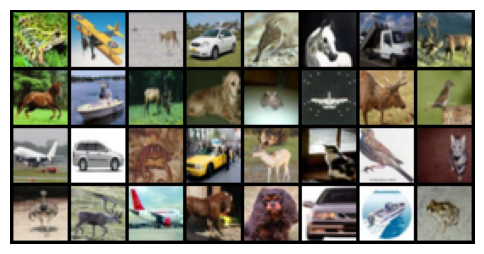

In [3]:
# %%
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*channels, [0.5]*channels)
])

trainset = torchvision.datasets.CIFAR10(root=data_dir, train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

def show_batch(dl):
    imgs, _ = next(iter(dl))
    grid = make_grid(imgs[:32] * 0.5 + 0.5, nrow=8)
    plt.figure(figsize=(6,6))
    plt.axis("off")
    plt.imshow(grid.permute(1,2,0))
    plt.show()

show_batch(trainloader)

In [4]:
# %%
class Generator(nn.Module):
    def __init__(self, latent_dim, ngf, channels):
        super().__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, ngf*4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf, channels, 4, 2, 1, bias=False),
            nn.Tanh(),
        )

    def forward(self, z):
        return self.net(z)


class Discriminator(nn.Module):
    def __init__(self, channels, ndf):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(channels, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf*2, ndf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf*4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.net(x).view(-1, 1)


netG = Generator(latent_dim, ngf, channels).to(device)
netD = Discriminator(channels, ndf).to(device)

print(netG)
print(netD)

Generator(
  (net): Sequential(
    (0): ConvTranspose2d(128, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)
Discriminator(
  (net): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), 

In [5]:
# %%
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

netG.apply(weights_init)
netD.apply(weights_init)

print("Weights initialized.")

Weights initialized.


In [6]:
# %%
criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

fixed_noise = torch.randn(64, latent_dim, 1, 1, device=device)

print("Setup complete.")

Setup complete.


In [7]:
# %%
G_losses = []
D_losses = []

print("Starting Training...")

for epoch in range(1, num_epochs+1):
    for i, (real_imgs, _) in enumerate(tqdm(trainloader)):
        bs = real_imgs.size(0)

        # Real labels = 1, fake = 0
        real_labels = torch.full((bs,1), 1.0, device=device)
        fake_labels = torch.full((bs,1), 0.0, device=device)

        real_imgs = real_imgs.to(device)

        # --------------------------
        #  Train Discriminator
        # --------------------------
        optimizerD.zero_grad()

        output_real = netD(real_imgs)
        loss_real = criterion(output_real, real_labels)

        noise = torch.randn(bs, latent_dim, 1, 1, device=device)
        fake_imgs = netG(noise)

        output_fake = netD(fake_imgs.detach())
        loss_fake = criterion(output_fake, fake_labels)

        loss_D = (loss_real + loss_fake) * 0.5
        loss_D.backward()
        optimizerD.step()

        # --------------------------
        #  Train Generator
        # --------------------------
        optimizerG.zero_grad()

        output = netD(fake_imgs)
        loss_G = criterion(output, real_labels)
        loss_G.backward()
        optimizerG.step()

    print(f"Epoch [{epoch}/{num_epochs}] - Loss D: {loss_D:.4f}, Loss G: {loss_G:.4f}")

    G_losses.append(loss_G.item())
    D_losses.append(loss_D.item())

    with torch.no_grad():
        fake = netG(fixed_noise).detach().cpu()
    grid = make_grid(fake * 0.5 + 0.5, nrow=8)
    save_image(grid, f"{out_dir}/epoch_{epoch:03d}.png")

Starting Training...


100%|██████████| 391/391 [00:18<00:00, 21.60it/s]


Epoch [1/30] - Loss D: 0.2774, Loss G: 4.7260


100%|██████████| 391/391 [00:19<00:00, 19.84it/s]


Epoch [2/30] - Loss D: 0.1638, Loss G: 3.5215


100%|██████████| 391/391 [00:15<00:00, 25.77it/s]


Epoch [3/30] - Loss D: 0.6861, Loss G: 6.4657


100%|██████████| 391/391 [00:14<00:00, 26.12it/s]


Epoch [4/30] - Loss D: 0.2864, Loss G: 2.8857


100%|██████████| 391/391 [00:16<00:00, 24.06it/s]


Epoch [5/30] - Loss D: 0.2927, Loss G: 2.9933


100%|██████████| 391/391 [00:15<00:00, 25.13it/s]


Epoch [6/30] - Loss D: 0.2740, Loss G: 2.2289


100%|██████████| 391/391 [00:15<00:00, 25.91it/s]


Epoch [7/30] - Loss D: 0.3353, Loss G: 2.6223


100%|██████████| 391/391 [00:15<00:00, 25.95it/s]


Epoch [8/30] - Loss D: 0.3520, Loss G: 2.0563


100%|██████████| 391/391 [00:16<00:00, 23.93it/s]


Epoch [9/30] - Loss D: 0.5250, Loss G: 3.0189


100%|██████████| 391/391 [00:15<00:00, 25.26it/s]


Epoch [10/30] - Loss D: 0.2322, Loss G: 2.8291


100%|██████████| 391/391 [00:14<00:00, 26.16it/s]


Epoch [11/30] - Loss D: 0.6057, Loss G: 1.2692


100%|██████████| 391/391 [00:15<00:00, 25.86it/s]


Epoch [12/30] - Loss D: 0.3456, Loss G: 1.8850


100%|██████████| 391/391 [00:14<00:00, 26.07it/s]


Epoch [13/30] - Loss D: 0.2507, Loss G: 2.1880


100%|██████████| 391/391 [00:15<00:00, 25.00it/s]


Epoch [14/30] - Loss D: 0.2346, Loss G: 2.6900


100%|██████████| 391/391 [00:15<00:00, 25.25it/s]


Epoch [15/30] - Loss D: 0.3549, Loss G: 1.2491


100%|██████████| 391/391 [00:14<00:00, 26.07it/s]


Epoch [16/30] - Loss D: 0.3395, Loss G: 2.9042


100%|██████████| 391/391 [00:15<00:00, 25.96it/s]


Epoch [17/30] - Loss D: 0.2494, Loss G: 1.8507


100%|██████████| 391/391 [00:16<00:00, 24.36it/s]


Epoch [18/30] - Loss D: 0.2474, Loss G: 2.7654


100%|██████████| 391/391 [00:16<00:00, 24.07it/s]


Epoch [19/30] - Loss D: 0.4007, Loss G: 1.3169


100%|██████████| 391/391 [00:15<00:00, 25.89it/s]


Epoch [20/30] - Loss D: 0.6512, Loss G: 1.2758


100%|██████████| 391/391 [00:15<00:00, 25.56it/s]


Epoch [21/30] - Loss D: 0.4025, Loss G: 1.7870


100%|██████████| 391/391 [00:15<00:00, 25.71it/s]


Epoch [22/30] - Loss D: 0.4748, Loss G: 2.8484


100%|██████████| 391/391 [00:15<00:00, 25.70it/s]


Epoch [23/30] - Loss D: 0.8521, Loss G: 5.5347


100%|██████████| 391/391 [00:15<00:00, 24.66it/s]


Epoch [24/30] - Loss D: 0.6498, Loss G: 2.6023


100%|██████████| 391/391 [00:15<00:00, 25.61it/s]


Epoch [25/30] - Loss D: 0.3468, Loss G: 2.3093


100%|██████████| 391/391 [00:14<00:00, 26.30it/s]


Epoch [26/30] - Loss D: 0.4173, Loss G: 1.1519


100%|██████████| 391/391 [00:14<00:00, 26.09it/s]


Epoch [27/30] - Loss D: 0.3236, Loss G: 2.3404


100%|██████████| 391/391 [00:15<00:00, 25.84it/s]


Epoch [28/30] - Loss D: 0.2634, Loss G: 2.5906


100%|██████████| 391/391 [00:16<00:00, 24.11it/s]


Epoch [29/30] - Loss D: 0.3050, Loss G: 1.5804


100%|██████████| 391/391 [00:15<00:00, 25.78it/s]

Epoch [30/30] - Loss D: 0.2777, Loss G: 2.2591


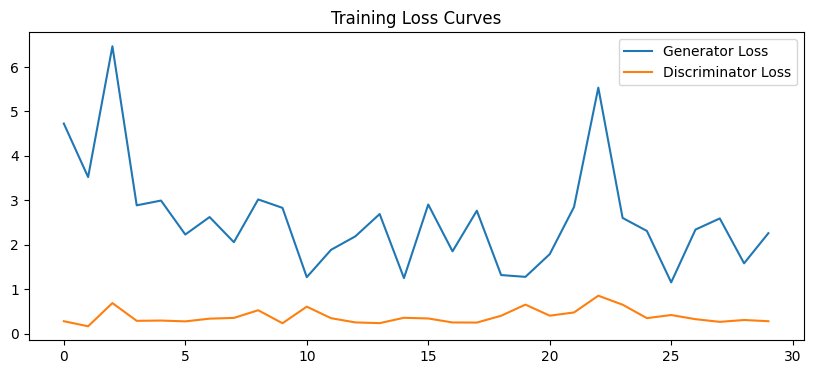

In [8]:
# %%
plt.figure(figsize=(10,4))
plt.plot(G_losses, label="Generator Loss")
plt.plot(D_losses, label="Discriminator Loss")
plt.legend()
plt.title("Training Loss Curves")
plt.show()

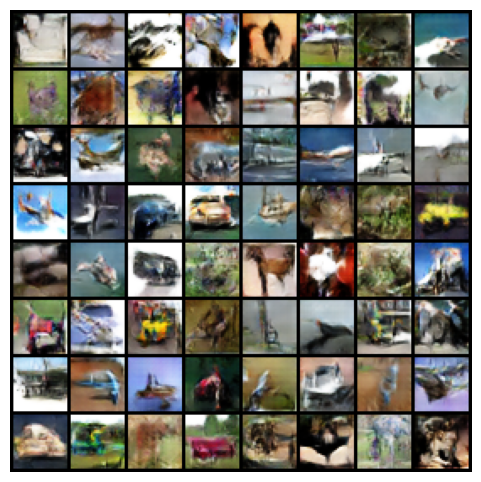

In [9]:
# %%
from PIL import Image

img = Image.open(f"{out_dir}/epoch_{num_epochs:03d}.png")
plt.figure(figsize=(6,6))
plt.axis("off")
plt.imshow(img)
plt.show()

In [10]:
# %%
torch.save(netG.state_dict(), f"{out_dir}/generator.pth")
torch.save(netD.state_dict(), f"{out_dir}/discriminator.pth")

print("Models saved.")

Models saved.
